In [1]:
import pandas as pd 
import numpy as np
import RNA
#import networkx as nx 
import matplotlib.pyplot as plt
#import graph_tool.all as gt 
from scipy.stats import levy

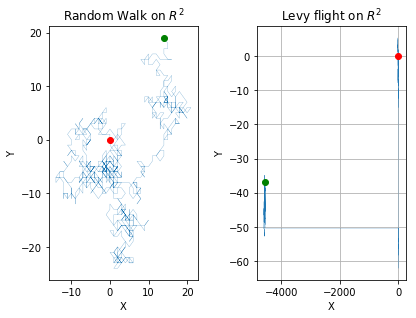

In [2]:

left = 0.125  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.02  # the bottom of the subplots of the figure
top = 0.9   # the top of the subplots of the figure
wspace = 0.4  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.2
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


Nb_step = 1000

#Simple Random Walk
init = (0,0)
data = []
data.append(list(init))
for i in range(Nb_step) : 
    step = np.random.choice([-1,0,1], 2)
    init = init + step
    data.append(list(init))
    
data = np.array(data)
plt.subplot(1,2,1)
plt.plot(data[:,0], data[:,1], linewidth=0.2)
plt.plot(0,0,'r-o')
plt.plot(data[-1][0],data[-1][1],'g-o')
plt.title(r"Random Walk on $R^2$")
plt.xlabel("X")
plt.ylabel("Y")

#Levy flight: Random Walk with step that follows Levy's distribution
init = (0,0)
data = []
for i in range(Nb_step) : 
    direction = np.random.choice([-1.,0, 1.], 2)
    
    step = levy.rvs(size=2,scale=10**(-4), loc=1)
    init = init + step*direction
    data.append(list(init))
    
data = np.array(data)
plt.subplot(1,2,2)
plt.plot(data[:,0], data[:,1], linewidth=0.2)
plt.plot(0,0,'r-o')
plt.plot(data[-1][0],data[-1][1],'g-o')
plt.title(r"Levy flight on $R^2$")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.savefig("SRW.pdf")
plt.show()

In [3]:
def mutate(sequence, mu) : 
    indexes_to_mutate = list(np.where(np.random.binomial(1,mu, len(sequence))==1)[0])
    mutant = list(sequence)
    for i in indexes_to_mutate: 
        mutant[i] = np.random.choice(['A', 'C','G','U'], 1)[0]
    return "".join(mutant)

def fitness(sequence, target): 
    strc = RNA.fold(sequence)[0]
    return 1./(1.+RNA.hamming_distance(strc, target))

def evaluate(pop,target): 
    return [fitness(seq, target) for seq in pop]
    

def select(pop, weights, size) : 
    
    return np.random.choice(pop,size=size, p=np.array(weights)/sum(weights))

def levy_rdv(a,b,size) : 
    levy_dat = levy.rvs(size=size)
    levy_ab = (b-a)*((levy_dat - min(levy_dat))/(max(levy_dat)-min(levy_dat))) + a
    return np.array(levy_ab, dtype=int)

def levy_mutation(pop) : 
    mutants = []
    nb_points = levy_rdv(1,len(pop[0]),len(pop))
    for i in range(len(pop)) : 
        indexes_to_mutate = np.random.choice(range(len(pop[i])), nb_points[i], replace=False)
        mutant = np.array(list(pop[i]))
        mutant[indexes_to_mutate] = np.random.choice(['A', 'C','G','U'], nb_points[i])
        
        mutants.append("".join(mutant))
        
    return mutants

def get_bp_position(structure) : 
    position = RNA.ptable(structure)
    position = list(position[1:])

    base_paire_pos = []
    for i in range(len(position)) :
        if position[i] != 0 :
            if (position[i]-1,i) in base_paire_pos : 
                continue; 
            else : 
                base_paire_pos.append((i,position[i]-1))

    return base_paire_pos


In [4]:
def rna_evo(target,init_pop, t, mu) : 
    t_n = 0 
    current_pop = np.copy(init_pop)
    fitnesses = evaluate(current_pop, target)
    while t_n < t and max(fitnesses) < 1. : 
          
        mutants = [mutate(seq, mu) for seq in current_pop]
        fitnesses = evaluate(mutants, target)
        selected = select(mutants,fitnesses, len(mutants))
        
        current_pop = np.copy(selected)
        t_n +=1 
        
        if t_n%10==0 :
            print ("Generation ", t_n , " with max fitness ", max(fitnesses))
          
    return current_pop[fitnesses.index(max(fitnesses))]

def rna_evo_with_levy(target,init_pop, t, pos, p_c, p_n) : 
    t_n = 0 
    current_pop = np.copy(init_pop)
    fitnesses = evaluate(current_pop, target)
    while t_n < t and max(fitnesses) < 1.: 
          
        mutants = levy_mutation(current_pop)#,pos, p_c, p_n )
        fitnesses = evaluate(mutants, target)
        selected = select(mutants,fitnesses, len(mutants))
        
        current_pop = np.copy(selected)
        t_n +=1 
        
        if t_n%10==0 :
            print ("Generation ", t_n , " with max fitness ", max(fitnesses))
          
    return mutants[fitnesses.index(max(fitnesses))]

In [5]:
def levy_adv_mutation(pop, pos, p_n, p_c) : 
    base_paire = ["GC","CG","AU","UA", "GU", "UG"]
    nucleotides = ["A", "G","U","C"]
    bp_pos = pos["bp_pos"]
    nbp_indexes = np.where(np.array(pos["p_table"])==-1)[0]
    mutants = []
    
    
    
    bp_points = levy_rdv(1,len(bp_pos),len(pop))
    nb_points = levy_rdv(1,len(nbp_indexes),len(pop))
    
    for i in range(len(pop)) : 
        mutant = np.array(list(pop[i]))
        
        #Mutate a base pair position
        bp_choice = np.random.choice(base_paire,bp_points[i], p=p_c)
        bp_indexes_to_mutate = np.random.choice(range(len(bp_pos)), bp_points[i],replace=False)
        bp_to_mutate = np.array(bp_pos)[bp_indexes_to_mutate]
        
        for j in range(bp_points[i]) : 
            mutant[bp_to_mutate[j][0]] =bp_choice[j][0]
            mutant[bp_to_mutate[j][1]] =bp_choice[j][1]
        
        #Mutate a non base pair position
        nbp_indexes_to_mutate = np.random.choice(list(nbp_indexes), nb_points[i], replace=False)
        mutant[nbp_indexes_to_mutate]= np.random.choice(['A', 'C','G','U'], nb_points[i],p=p_n)
        
        mutants.append("".join(mutant))
        
    return mutants

In [6]:
target = "((....)).((....)).((....)).((....))"
p_n = [0.25, 0.25, .25, .25]
p_c = [0.2, 0.2, 0.1, 0.1, 0.2, 0.2]
pos= {
    "p_table": list(np.array(RNA.ptable(target)[1:])-1), 
    
    "bp_pos": get_bp_position(target)                  
}

print(pos)

pop = []

for i in range(100): 
    rna = np.random.choice(['A','C','G','U'],len(target))
    pop.append(''.join(rna))

print(pop)

{'p_table': [7, 6, -1, -1, -1, -1, 1, 0, -1, 16, 15, -1, -1, -1, -1, 10, 9, -1, 25, 24, -1, -1, -1, -1, 19, 18, -1, 34, 33, -1, -1, -1, -1, 28, 27], 'bp_pos': [(0, 7), (1, 6), (9, 16), (10, 15), (18, 25), (19, 24), (27, 34), (28, 33)]}
['GGUCCCGUGAAGACCGAACGGUAUAUAUAAUCAUA', 'UAGACCGAGCACUUUGCCUGGUGUCAACCUAUUCA', 'GACUGAAGGCCGUUUCGUUCCGGUUCGCACGUCCG', 'GCAAAUUAGUAAACUCGGCGGUCACGAAGUCGCUG', 'UAGGACUCUUCAAUGCGGUGUGGCUGUGUUGGGGG', 'UACUAUUUCGACCCCCAACCCAGUCUCCAUCCGGU', 'UGACCAUCAUGUGUUGGCCUACUAGCAUGACCUUU', 'CAUUGUCAUCCUUAUCCCACCAAUGACGUUUUUGC', 'GAGGUUGUAGAGGAAAUGACGGUGCUUUACGUAUC', 'CUUGGCAGUCAUUUCGGCCAAGAUACAGUUUCGUC', 'ACUGCCUUUUAAAACGCAGAGAUUACUCAUGCAUU', 'ACACUACCACCGUCGCUUCCUUAAGAGUCGAGGUC', 'CCAUUCGCUACGUUGGCUGGCCCUCGGCAUUGAAG', 'CCCAUCCGUCUAUCAAAUAGUCUCUACGCCACCCU', 'UUCUGAUGCGUUGUCGCCCUUCGAAAGAGAAGGCU', 'ACUAAACCCUCGCGAAGUUCCGUUGUUGCGGGUCU', 'UCAUAUGGAUGGGAUAGUUCGUCGAAACACGAUAG', 'GUGAUGUAAAAGUUGAGGUGGGUCUGUCAGACCAC', 'CGUUCAGGAUUUCUUUAUGUUUUAGAACAAGUCCA', 'GUAAGUUGGAGUGGUAUUCUA

In [7]:
pop = []

for i in range(200): 
    rna = np.random.choice(['A','C','G','U'],len(target))
    pop.append(''.join(rna))


rna_evo_with_levy(target,pop,2000,pos,p_n, p_c) 

Generation  10  with max fitness  0.07692307692307693
Generation  20  with max fitness  0.07692307692307693
Generation  30  with max fitness  0.07142857142857142
Generation  40  with max fitness  0.09090909090909091
Generation  50  with max fitness  0.09090909090909091
Generation  60  with max fitness  0.09090909090909091
Generation  70  with max fitness  0.09090909090909091
Generation  80  with max fitness  0.09090909090909091
Generation  90  with max fitness  0.09090909090909091
Generation  100  with max fitness  0.09090909090909091
Generation  110  with max fitness  0.08333333333333333
Generation  120  with max fitness  0.08333333333333333
Generation  130  with max fitness  0.09090909090909091
Generation  140  with max fitness  0.09090909090909091
Generation  150  with max fitness  0.09090909090909091
Generation  160  with max fitness  0.09090909090909091
Generation  170  with max fitness  0.09090909090909091
Generation  180  with max fitness  0.1111111111111111
Generation  190  wit

Generation  1570  with max fitness  0.2
Generation  1580  with max fitness  0.2
Generation  1590  with max fitness  0.2
Generation  1600  with max fitness  0.2
Generation  1610  with max fitness  0.2
Generation  1620  with max fitness  0.2
Generation  1630  with max fitness  0.2
Generation  1640  with max fitness  0.2
Generation  1650  with max fitness  0.2
Generation  1660  with max fitness  0.2
Generation  1670  with max fitness  0.2
Generation  1680  with max fitness  0.2
Generation  1690  with max fitness  0.2
Generation  1700  with max fitness  0.2
Generation  1710  with max fitness  0.2
Generation  1720  with max fitness  0.2
Generation  1730  with max fitness  0.2
Generation  1740  with max fitness  0.2
Generation  1750  with max fitness  0.2
Generation  1760  with max fitness  0.2
Generation  1770  with max fitness  0.2
Generation  1780  with max fitness  0.2
Generation  1790  with max fitness  0.2
Generation  1800  with max fitness  0.2
Generation  1810  with max fitness  0.2


'GGGCCCGCAGAUUUAUCGGCAUAACCACCUUCUGG'

In [15]:
RNA.fold("GCGGAAAUAUCGUCGGAGAAUAGAGCAGGGUCACC")

['((.......((....)).......)).((....))', -3.0999999046325684]

In [35]:
rna_evo(target, pop,2000,1/18.)

Generation  10  with max fitness  0.06666666666666667
Generation  20  with max fitness  0.08333333333333333
Generation  30  with max fitness  0.06666666666666667
Generation  40  with max fitness  0.07142857142857142
Generation  50  with max fitness  0.06666666666666667
Generation  60  with max fitness  0.07692307692307693
Generation  70  with max fitness  0.07142857142857142
Generation  80  with max fitness  0.07142857142857142
Generation  90  with max fitness  0.06666666666666667
Generation  100  with max fitness  0.07142857142857142
Generation  110  with max fitness  0.07142857142857142
Generation  120  with max fitness  0.06666666666666667
Generation  130  with max fitness  0.06666666666666667
Generation  140  with max fitness  0.07692307692307693
Generation  150  with max fitness  0.07692307692307693
Generation  160  with max fitness  0.07692307692307693
Generation  170  with max fitness  0.07142857142857142
Generation  180  with max fitness  0.06666666666666667
Generation  190  wi

Generation  1500  with max fitness  0.06666666666666667
Generation  1510  with max fitness  0.07142857142857142
Generation  1520  with max fitness  0.06666666666666667
Generation  1530  with max fitness  0.07692307692307693
Generation  1540  with max fitness  0.08333333333333333
Generation  1550  with max fitness  0.07692307692307693
Generation  1560  with max fitness  0.07142857142857142
Generation  1570  with max fitness  0.07692307692307693
Generation  1580  with max fitness  0.07692307692307693
Generation  1590  with max fitness  0.07692307692307693
Generation  1600  with max fitness  0.07692307692307693
Generation  1610  with max fitness  0.07142857142857142
Generation  1620  with max fitness  0.07692307692307693
Generation  1630  with max fitness  0.07142857142857142
Generation  1640  with max fitness  0.09090909090909091
Generation  1650  with max fitness  0.07692307692307693
Generation  1660  with max fitness  0.07692307692307693
Generation  1670  with max fitness  0.0666666666

'GAAUUAAAUACUGCAAACCCAGUGGUCGUGGAUGC'

In [34]:
np.random.binomial(1,1/35., 35),1/35.

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0.02857142857142857)

In [168]:
result = []
for i in range(100): 
    print(i)
    result.append([rna_evo(target, pop,100,1/18.),rna_evo_with_levy(target,pop, t=100)])

0
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.14285714285714285
Generation  30  with max fitness  0.1111111111111111
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.3333333333333333
Generation  80  with max fitness  0.3333333333333333
Generation  90  with max fitness  0.3333333333333333
Generation  100  with max fitness  0.3333333333333333
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.3333333333333333
Generation  30  with max fitness  0.3333333333333333
Generation  40  with max fitness  0.3333333333333333
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
1
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Genera

Generation  20  with max fitness  0.14285714285714285
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.3333333333333333
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
13
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.14285714285714285
Generation  30  with max fitness  0.14285714285714285
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Gene

Generation  80  with max fitness  0.3333333333333333
Generation  90  with max fitness  0.3333333333333333
Generation  100  with max fitness  0.3333333333333333
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.3333333333333333
25
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.14285714285714285
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.14285714285714285
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.1111111111111111
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.

Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.3333333333333333
37
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.3333333333333333
Generation  30  with max fitness  0.3333333333333333
Generation  40  with max fitness  0.3333333333333333
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.3333333333333333
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
38
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.1111111111111111
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.14285714285714285
Ge

Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
49
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitn

Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
60
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.14285714285714285
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
Generation  10  with max fitness  0.2
Generation  20  with max fitness  

Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.3333333333333333
Generation  90  with max fitness  0.3333333333333333
Generation  100  with max fitness  0.2
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.14285714285714285
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
73
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with 

Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
84
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.3333333333333333
Generation  50  with max fitness  0.2
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.3333333333333333
Generation  90  with max fitness  0.3333333333333333
Generation  100  with max fitness  0.3333333333333333
85
Generation  10  with max fitness  0.1111111111111111
Generation  20  with max fitness  0.1111111111111111
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  

Generation  30  with max fitness  0.1111111111111111
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.14285714285714285
Generation  70  with max fitness  0.125
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.14285714285714285
Generation  100  with max fitness  0.2
Generation  10  with max fitness  0.14285714285714285
Generation  20  with max fitness  0.14285714285714285
Generation  30  with max fitness  0.2
Generation  40  with max fitness  0.2
Generation  50  with max fitness  0.2
Generation  60  with max fitness  0.2
Generation  70  with max fitness  0.2
Generation  80  with max fitness  0.2
Generation  90  with max fitness  0.2
Generation  100  with max fitness  0.2
97
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Generation  10  with max fitness  0.2
Generation  20  with max fitness  0.2
Generation  30  with max fitness  0.2
Ge

In [171]:
GCGGAAAUAUCGUCGGAGAAUAGAGCAGGGUCACC

['..................', 0.0]
['((....))..........', -0.4000000059604645]
['..................', 0.0]
['...((((....))))...', -2.0999999046325684]
['(((....)))........', -2.5]
['((....))..........', -0.10000000149011612]
['((....))..((....))', -2.0]
['((((......))))....', -4.800000190734863]
['((....))..........', -1.2999999523162842]
['((....))..........', -0.5]
['...(((.....)))....', -3.4000000953674316]
['..................', 0.0]
['((....))..........', -1.0]
['((....))..........', -1.0]
['((....))..........', -0.20000000298023224]
['....(((......)))..', -1.899999976158142]
['((....))..........', -1.0]
['((........))......', -1.100000023841858]
['((....))..........', -1.0]
['((....))..........', -1.0]
['((....))..........', -0.5]
['...((.(((...))).))', -1.5]
['((....))..........', -1.0]
['((....))..........', -0.5]
['.......((((...))))', -2.200000047683716]
['((....))..........', -0.5]
['((....))..........', -1.0]
['((((....))))......', -1.2000000476837158]
['..................', 0.0]


In [76]:
levy_pdf = lambda x: (1./(np.sqrt(2*np.pi)*(x**3)))*np.exp(-1./(2*x))
x = np.random.uniform(0.04,0.9,100000)
y = np.random.uniform( 0,4.290224637285348,100000)
print ('fine')
accepted_x = []
accepted_y = y[y<levy_pdf(x)]
accepted_x = x[y<levy_pdf(x)]

fine


(array([9634., 7170., 5158., 4219., 3502., 2892., 2307., 1851., 1321.,
         694.]),
 array([6.27375921e-05, 4.28598859e-01, 8.57134980e-01, 1.28567110e+00,
        1.71420722e+00, 2.14274334e+00, 2.57127947e+00, 2.99981559e+00,
        3.42835171e+00, 3.85688783e+00, 4.28542395e+00]),
 <a list of 10 Patch objects>)

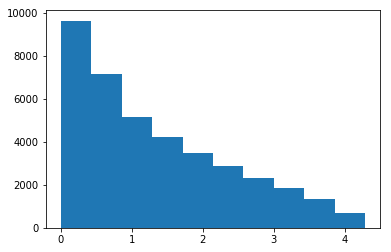

In [78]:
plt.hist(accepted_y)

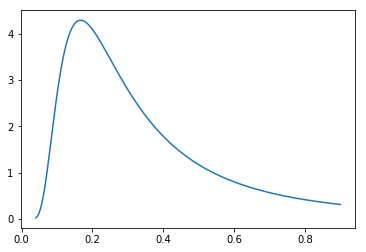

In [74]:
x = np.linspace(0.04,0.9, 1000)
plt.plot(x, levy_pdf(x))

In [75]:
print(max(levy_pdf(x)))

4.290224637285348


(array([998.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.01654608e-01, 1.44042991e+05, 2.88085880e+05, 4.32128769e+05,
        5.76171657e+05, 7.20214546e+05, 8.64257435e+05, 1.00830032e+06,
        1.15234321e+06, 1.29638610e+06, 1.44042899e+06]),
 <a list of 10 Patch objects>)

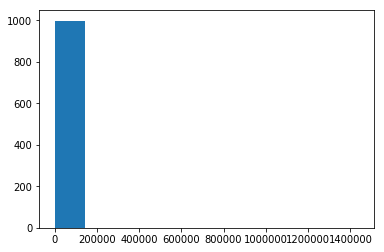

In [63]:
levy_dat = levy.rvs(size=1000)
plt.hist(levy_dat)


In [64]:
levy.rdv()

AttributeError: 'levy_gen' object has no attribute 'rdv'

In [85]:
min(levy_dat)

0.09251143367425851

In [128]:
levy_rdv(1,10,20)

array([10,  1,  1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,
        1,  2,  1])

(array([198.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1. ,  4.4,  7.8, 11.2, 14.6, 18. , 21.4, 24.8, 28.2, 31.6, 35. ]),
 <a list of 10 Patch objects>)

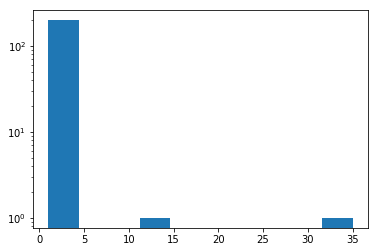

In [38]:
plt.hist(levy_rdv(1,35,200), bins=10, log=True)

In [ ]:
a = 1
b = 100
levy_dat = levy.rvs(size=1000)
levy_ab = (b-a)*((levy_dat - min(levy_dat))/(max(levy_dat)-min(levy_dat))) + a
plt.plot(levy_ab)

In [55]:
import numpy

def nthHarmonic(N,s) :

    harmonic = 1.00
    for i in range(2, N + 1) :
        harmonic += 1 / i**s

    return harmonic

def zipf_rvgen(low, high, a, N, size) : 
    choices = numpy.array(range(low, high+1))
    probs = choices**(-a) / nthHarmonic(N,a)
    return numpy.random.choice(choices,p=numpy.array(probs)/sum(probs),size=size)

def bino(low, high, mu, size):
    points = []
    for i in range(size) : 
        point = numpy.random.binomial(1,mu,high)
        points.append(len(numpy.where(point==1)[0]))
    return points 

def levy_rdv(a,b,size) : 
    levy_dat = levy.rvs(size=size)
    #levy_ab = (b-a)*((levy_dat - min(levy_dat))/(max(levy_dat)-min(levy_dat))) + a
    return levy_dat #np.array(levy_ab, dtype=int)

In [40]:
zipf_dist = zipf_rvgen(1,35,1.5,35,size=200)

In [41]:
import matplotlib.pyplot as plt

(array([97.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([1.06544981e-01, 2.32162935e+04, 4.64324804e+04, 6.96486673e+04,
        9.28648543e+04, 1.16081041e+05, 1.39297228e+05, 1.62513415e+05,
        1.85729602e+05, 2.08945789e+05, 2.32161976e+05]),
 <a list of 10 Patch objects>)

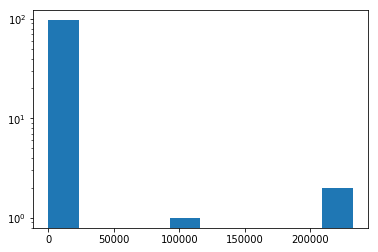

In [59]:
levy_dist = levy_rdv(1,35,size=100)
plt.hist(levy_dist, log=True)

(array([89.,  0., 63.,  0., 34.,  0., 12.,  0.,  1.,  1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

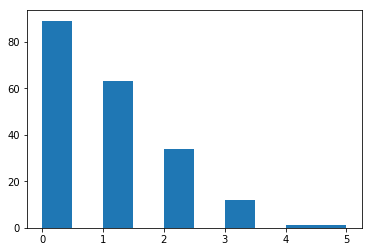

In [12]:
bino_dist = bino(1,35,1./35,size=200)
plt.hist(bino_dist)

# 1. Mutation mode Analisys

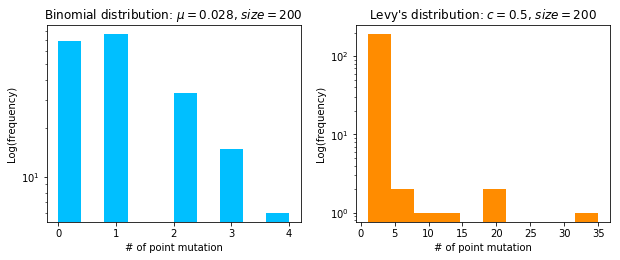

In [47]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

figure = plt.figure(constrained_layout=True, figsize=(8.5,3.5))
gs = figure.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.48, wspace=0.05)
ax = figure.add_subplot(gs[0,0])
#ax.spines["right"].set_visible(False)
#ax.spines["top"].set_visible(False)
plt.title("Binomial distribution: $\mu=0.028$, $size=200$")
plt.xlabel("# of point mutation")
plt.ylabel("Log(frequency)")
ax.hist(bino(1,35,1./35,size=200),color="deepskyblue", log=True)

ax = figure.add_subplot(gs[0,1])
#ax.spines["right"].set_visible(False)
#ax.spines["top"].set_visible(False)
plt.title("Levy's distribution: $c=0.5$, $size=200$")
plt.xlabel("# of point mutation", family='sans-serif')
plt.ylabel("Log(frequency)")
ax.hist(levy_dist, log=True, color='darkorange')

plt.savefig("histo1.pdf")
plt.show()



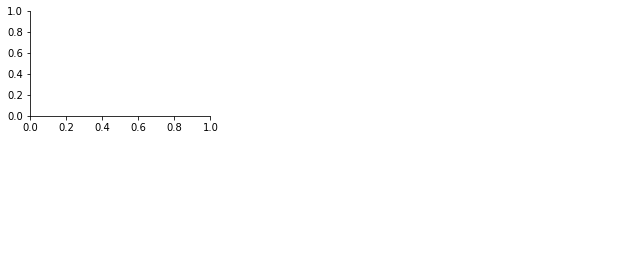

In [10]:
figure = plt.figure(constrained_layout=True, figsize=(8.5,3.5))
gs = figure.add_gridspec(nrows=2, ncols=3, left=0.05, right=0.48, wspace=0.05)
ax = figure.add_subplot(gs[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

In [11]:
#LOAD DATA for plotting.... 
import json 

#1.distinct structure data 

with open('bino_distinct_strcs.json', 'rb') as bf :
    bino_distinct_strcs = json.load(bf)

with open('levy_distinct_strcs.json', 'rb') as bf :
    levy_distinct_strcs = json.load(bf)

with open('zipf_distinct_strcs.json', 'rb') as bf :
    zipf_distinct_strcs = json.load(bf)

with open('max_generation.json', 'rb') as bf :
    max_generation = json.load(bf)

plt.boxplot(max_generation.values(), labels=['zipf','bino','levy'])

FileNotFoundError: [Errno 2] No such file or directory: 'bino_distinct_strcs.json'

In [ ]:
figure = plt.figure(constrained_layout=True, figsize=(10,6))
gs = figure.add_gridspec(nrows=2, ncols=3, left=0.05, right=0.48, wspace=0.05)


# 1. Plot on distinct structures
ax = figure.add_subplot(gs[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('(a)')
plt.xlabel('generation')
plt.ylabel('# of distinct structure')
j = 1 
for line in bino_distinct_strcs.values() :
    if j == 1: 
        ax.plot(line, 'b', linewidth=0.3, label='bino')
        j = j +1 
    ax.plot(line, 'b', linewidth=0.3)

j = 1 
for line in levy_distinct_strcs.values() :
    if j == 1: 
        ax.plot(line, 'r', linewidth=0.3, label='levy')
        j = j +1 
    ax.plot(line, 'r', linewidth=0.3)
j=1   
for line in zipf_distinct_strcs.values() :
    if j == 1: 
        ax.plot(line, 'g', linewidth=0.3, label='zipf')
        j = j +1 
    ax.plot(line, 'g', linewidth=0.3)
plt.legend()

# 2. Plot on max # of generation 
ax = figure.add_subplot(gs[0,1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('(b)')
plt.ylabel('# of generation')
ax.boxplot(max_generation.values(), labels=['zipf','bino','levy'])

# 3. Plot histogram of max # of generation 
ax = figure.add_subplot(gs[0,2])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('(c)')
plt.ylabel('# of generation')
ax.hist(max_generation.values(),color=['g', 'r', 'b'], label=['zipf', 'bino', 'levy'])
plt.legend()


# 4. Plot on # of success of Zipf's M 
ax = figure.add_subplot(gs[1,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('(d): zipf M')
plt.ylabel(r'# of success over $100$ run')
plt.xlabel(r'Exponent parameter ($a$)')

# 5. Plot on # of success of Levy's M 
ax = figure.add_subplot(gs[1,1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('(e): levy M')
plt.xlabel(r'scale parameter ($s$)')

# 6. Plot on # of success of Levy's M 
ax = figure.add_subplot(gs[1,2])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title('(f): biono M')
plt.xlabel(r'mutation rate ($\mu$)')

# Own Implementation of a discrete Levy Distribution

In [2]:
def levy_pdf(x,mu, c) : 
    return np.sqrt(c/2*np.pi) *(np.exp(-c/2.*(x-mu))/((x-mu)**1.5))

In [7]:
pbs = []
mu=1
c=6.5

for i in range(2,37) : 
    pbs.append(levy_pdf(i,mu,c))

In [8]:
print (pbs, len(pbs))

([0.12389664625112438, 0.0016984684771843028, 3.584788487697811e-05, 9.028141663239629e-07, 2.50481859912751e-08, 7.388348018879432e-10, 2.273369837130341e-11, 7.21481346055277e-13, 2.344440725835047e-14, 7.761505239206945e-16, 2.6085541773245282e-17, 8.876871916592573e-19, 3.0525285037108316e-20, 1.0590723670435942e-21, 3.7027444143329456e-23, 1.3032375474104353e-24, 4.613952398091215e-26, 1.6420284135128022e-27, 5.870863160861798e-29, 2.1078043654020887e-30, 7.596075712518411e-32, 2.746800637524588e-33, 9.963509530121158e-35, 3.624350295295598e-36, 1.3218432242523377e-37, 4.83251125360437e-39, 1.7706396435687949e-40, 6.501023210953774e-42, 2.3914686971954813e-43, 8.812979282572207e-45, 3.2531570085415006e-46, 1.202722765259789e-47, 4.453100769254874e-49, 1.6510415049043256e-50, 6.129389694503583e-52], 35)


In [12]:
levy_points = []
for i in range(200) : 
    levy_points.append(np.random.choice(range(1,36),1, p=np.array(pbs)/sum(pbs))[0])

(array([99.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

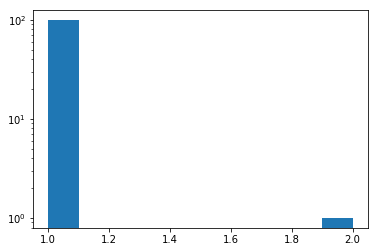

In [17]:
levy_points = []
pbs = levy_pdf(np.array(range(2,37)),1,5.5)

    
levy_points = np.random.choice(range(1,36),100, p=np.array(pbs)/sum(pbs))
plt.hist(levy_points, log=True)

In [21]:
import numpy 
def nthHarmonic(N,s) :

    harmonic = 1.00
    for i in range(2, N + 1) :
        harmonic += 1 / i**s

    return harmonic

def zipf_rvgen(low, high, N, size, a=6.) : 
    choices = numpy.array(range(low, high+1))
    probs = choices**(-a) / nthHarmonic(N,a)
    return numpy.random.choice(choices,p=numpy.array(probs)/sum(probs),size=size)
    

In [22]:
RNA.hamming_distance('........(((((((..((....)).)))))))...((((((....((((((...((...((((((....))))))..))...))))))(((...(.((((((((..........)))))))).)..))).............))))))((((...(((....)))..)))).............((..(((((....))))).....))..','........(((((((..((....)).)))))))...((((((....((((((...((...((((((....))))))..))...))))))(((...(.((((((((..........)))))))).)..))).............))))))((((..((((....))).))))).............((..(((((....))))).....))..')

2

(array([85., 11.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <a list of 10 Patch objects>)

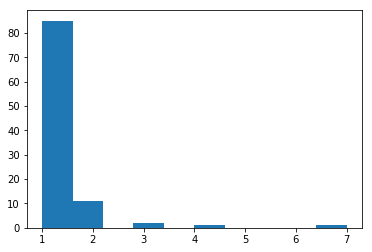

In [27]:
zipf_points = zipf_rvgen(1,35,35,100, 5.5)
plt.hist(zipf_points)